
# Рекуррентная нейронная сеть для определения категории имени по символам

В этом примере построим рекуррентную нейронную сеть, которая будет пытаться определить какой категории (языку) принадлежит имя (фамилия). Эта сеть рассматривает имя как последовательность символов. Несомненно, по написанию символов имени можно с некоторой уверенностью, хоть и не 100%, определить язык.

Рекуррентная сеть принимает на вход не только текущий элемент входной поcледовательности, но и свое предыдущее состояние, это вариант сети Элмана.

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/DiagramElmanNet_english.png/1920px-DiagramElmanNet_english.png)

Сеть читает слова посимвольно, возвращая каждый раз скрытое состояние и выход (категории).

Возвращаются уровни уверенности в категории (языке).

В обучающем наборе имена на 18 языках.


It would also be useful to know about RNNs and how they work:



# Подготовка данных
Загрузим данные [отсюда](https://download.pytorch.org/tutorial/data.zip), распакуем архив.

В архиве директории ``data/names`` имеется 18 текстовых файлов `[Language].txt`. Каждый файл содержит имена, по одному на строке. Возможны символы Unicode, потребуется конвертировать в ASCII.

Создадим словарь имен и языков ``{language: [names ...]}``.

In [1]:
%matplotlib inline

In [2]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -o data.zip

--2024-04-10 08:38:50--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.225.55, 18.239.225.41, 18.239.225.75, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.225.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2024-04-10 08:38:50 (21.4 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/It

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

# все найденные файлы
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

# символы ASCII
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Переводим Unicode в ASCII,(https://stackoverflow.com/a/518232/2809427)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# проверим
print(unicodeToAscii('Ślusàrski'))

# словарь всех имен для языков
category_lines = {}
all_categories = []

# читаем файл, разделяем на строки
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# для всех файлов = языков
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories) # число категорий

['data/names/Vietnamese.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Italian.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/English.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/Russian.txt']
Slusarski


В ``category_lines`` словарь имен для языков. В
``all_categories`` список всех языков (категорий). ``n_categories`` - число категорий.




In [4]:
# проверим
from random import choices
print(*choices(category_lines['Russian'],k=5),sep='\n')

Katsenelenbaum
Dzhuro
Pyrin
Ryjkovsky
Pokhojaev


In [5]:
print(*all_categories, sep='\n')

Vietnamese
Korean
Portuguese
Czech
Scottish
Italian
German
Japanese
Arabic
English
Greek
Dutch
Polish
Chinese
Spanish
French
Irish
Russian


# Кодирование имен

Символы будем представлять унитарными векторами размера ``<1 x n_letters>``.

Слово (имя) тогда является матрицей таких векторов
``<line_length x 1 x n_letters>``.

Для PyTorch также указываем размер пакетов, в нашем случае 1.




In [6]:
import torch

# индекс символа в словаре символов "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# символ в унитарный вектор <1 x n_letters>
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Строка (слово) в матрицу унитарных векторов <line_length x 1 x n_letters>,
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) # обратите внимание на размерность тензора
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Создание рекуррентной сети

Архитектура нашей сети практически повторяет модуль
[RNN](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net)

Она содержит два персептронных слоя, один скрытый, один выходной. На выходе активация [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html). Отличия LogSoftmax от Softmax можно посмотреть [здесь](https://medium.com/@AbhiramiVS/softmax-vs-logsoftmax-eb94254445a2). Скрытый слой не использует активацию.

Текущий вход и предыдущий выход скрытого слоя объединяются (конкатенируются). И скрытый и выходной слои используют текущий вход, поэтому это не совсем последовательная архитектура.

![img](https://i.imgur.com/Z2xbySO.png)





In [7]:
import torch.nn as nn
# Класс для сети
class RNN(nn.Module):
    # инициализация
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__() # класс родителя

        self.hidden_size = hidden_size # размер скрытого слоя

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # скрытый слой с параметрами
        self.i2o = nn.Linear(input_size + hidden_size, output_size)  # выходной слой с параметрами
        self.logsoftmax = nn.LogSoftmax(dim=1)  # активация для выхода
    # расчет выхода сети
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # объединение текущего входа и предыдущего состояния
        hidden = self.i2h(combined) # обновляем состояние скрытого слоя
        output = self.i2o(combined) # выход
        output = self.logsoftmax(output) # активация
        return output, hidden
    # инициализация состояния скрытого слоя (нулями)
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
#input_size=[[57],[128]]
#[print(torch.rand(2, *in_size).type(torch.FloatTensor)) for in_size in input_size]



In [8]:
# посмотрим на сеть
from torchsummary import summary
summary(rnn,[[n_letters],[n_hidden]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          23,808
            Linear-2                   [-1, 18]           3,348
        LogSoftmax-3                   [-1, 18]               0
Total params: 27,156
Trainable params: 27,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


В качестве входа подаются унитарные вектора символов, мы будем брать их из среза слова от ``lineToTensor``.




In [9]:
# Просто пример для символа
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.8242, -2.9198, -2.9170, -2.9357, -2.8388, -2.8898, -2.9743, -2.9050,
         -2.9062, -2.8306, -2.8256, -2.8772, -2.9210, -2.9435, -2.8981, -2.8856,
         -2.8586, -2.8912]], grad_fn=<LogSoftmaxBackward0>)


In [10]:
# срез из слова
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8242, -2.9198, -2.9170, -2.9357, -2.8388, -2.8898, -2.9743, -2.9050,
         -2.9062, -2.8306, -2.8256, -2.8772, -2.9210, -2.9435, -2.8981, -2.8856,
         -2.8586, -2.8912]], grad_fn=<LogSoftmaxBackward0>)


Выход имеет размерность ``<1 x n_categories>``.




# Обучение
## Подготовка к обучения
Несколько функций для дальнейшей работы:
- получение названия самой уверенной категории
- случайный выбор примера для обучения




In [11]:
# получение названия и номера самой уверенной категории
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 0)


In [12]:
import random
# случайный выбор элемента
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]
# создание обучающего примера
def randomTrainingExample():
    category = randomChoice(all_categories) # случайно выбираем язык
    line = randomChoice(category_lines[category]) # случайно выбираем слово (имя)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # указание учителя = номер категории
    line_tensor = lineToTensor(line) # вход
    return category, line, category_tensor, line_tensor

# проверяем
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Zhuravel
category = Chinese / line = Cheng
category = Irish / line = Cormac
category = Chinese / line = Huang
category = German / line = Stuber
category = Arabic / line = Mifsud
category = English / line = Embleton
category = Polish / line = Wawrzaszek
category = French / line = Bouchard
category = Scottish / line = Walker


## Обучение

Для ``LogSoftmax`` используем функцию ошибки [``NLLLoss``](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)




In [13]:
criterion = nn.NLLLoss() # функция ошибки

В цикле для каждого обучающего примера:

-  создаем пример входа и указания учителя
-  инициализируем состояние сети
-  для каждого символа в слове

   -  обновляем состояние сети

-  последний выход сравниваем с указанием учителя
-  считаем производные и обновляем параметры
-  возвращаем выход.




In [14]:
learning_rate = 0.005 # шаг обучения

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # инициализируем состояние скрытого слоя

    rnn.zero_grad() # сбрасываем накопленные градиенты

    for i in range(line_tensor.size()[0]): # расчитываем выходы в цикле по всем символам
        output, hidden = rnn(line_tensor[i], hidden) # обновляем состояние и выходы

    loss = criterion(output, category_tensor) # функция ошибки с последним выходом
    loss.backward() # автодифференцирование

    # градиентный спуск
    for p in rnn.parameters(): # для всех параметров
        p.data.add_(p.grad.data, alpha=-learning_rate) # обновляем значения параметров, знак "-"" для градиентного спуска

    return output, loss.item()

In [15]:
# обучение 5-10 минут
import time
import math
n_iters = 100000 # число итераций обучения 500000
print_every = 5000 # как часто печатать информацию
plot_every = 5000 # как часто рисовать

# прогресс
current_loss = 0
all_losses = []
# расчет времени
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time() # запускаем таймер

for iter in range(1, n_iters + 1): # в цикле по числу итераций
    category, line, category_tensor, line_tensor = randomTrainingExample() # создаем (выбираем) обучающий пример
    output, loss = train(category_tensor, line_tensor) # обучаем на этом примере
    current_loss += loss # накопленная за период рисования ошибка

    # иногда печатаем прогресс
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output) # текущая предсказанная категория
        correct = '✓' if guess == category else '✗ (%s)' % category # совпадает?
        print('%6d %3d%% (%6s) %5.4f %15s / %15s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # для рисования
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  5000   5% ( 0m 6s) 0.9678      Stroggylis /           Greek ✓
 10000  10% (0m 14s) 2.2985          D'cruz /         Spanish ✗ (Portuguese)
 15000  15% (0m 20s) 3.0301          Botros /           Greek ✗ (Arabic)
 20000  20% (0m 28s) 3.0294       Haenraats /         Italian ✗ (Dutch)
 25000  25% (0m 35s) 2.4168           Ganem /           Dutch ✗ (Arabic)
 30000  30% (0m 42s) 1.7753            Diep /      Vietnamese ✓
 35000  35% (0m 51s) 1.5958        Palmeiro /         Italian ✗ (Portuguese)
 40000  40% (0m 57s) 2.1056          Hayden /          Arabic ✗ (Irish)
 45000  45% ( 1m 5s) 0.9752          Koolen /           Dutch ✓
 50000  50% (1m 12s) 4.1601         Mencher /           Dutch ✗ (Polish)
 55000  55% (1m 20s) 2.5822           Giang /           Irish ✗ (Vietnamese)
 60000  60% (1m 27s) 0.0279      Sokolowski /          Polish ✓
 65000  65% (1m 34s) 0.5877        Christie /        Scottish ✓
 70000  70% (1m 41s) 0.2423        Vyaltsin /         Russian ✓
 75000  75% (1m 48s) 0

### Рисуем результаты




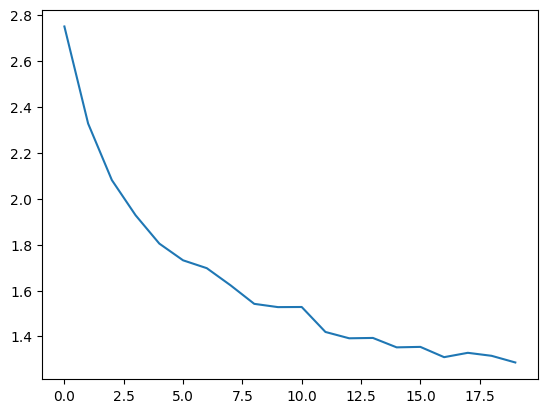

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Проверка работы сети

Построим матрицу потерь для обученной сети.




<ipython-input-17-0c92eb9e2321>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-17-0c92eb9e2321>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


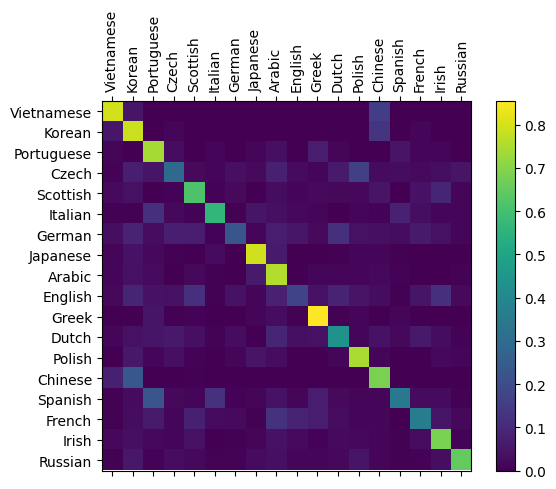

In [17]:
#
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 50000

# расчет выхода обученной сети
def evaluate(line_tensor):
    hidden = rnn.initHidden() # инициализация состояния

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden) # считаем выход

    return output

# проверяем на нескольких примерах
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample() # выбор примера
    output = evaluate(line_tensor) # расчет выхода
    guess, guess_i = categoryFromOutput(output) # предсказанная категория
    category_i = all_categories.index(category) # настоящая категория
    confusion[category_i][guess_i] += 1 # обновляем клетку матрицы потерь

# нормализуем матрицу потерь
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# рисуем
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

#
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

#
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Имена на английском распознались хуже всех, как вы думаете почему?




# Проверка для своих имен




In [19]:
# расчет категории
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad(): # здесь нам автодифференцирование не нужно
        output = evaluate(lineToTensor(input_line)) # расчитываем выход

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True) # выбираем несколько самых уверенных
        predictions = []

        for i in range(n_predictions):
            value = torch.exp(topv[0][i]).item() # возьмем экспоненту, чтобы было привычно как с softmax
            category_index = topi[0][i].item() # категории
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Pantiukhin')


> Dovesky
(0.59) Russian
(0.32) Czech
(0.05) English

> Jackson
(0.57) Scottish
(0.12) Korean
(0.11) English

> Satoshi
(0.49) Arabic
(0.21) Japanese
(0.12) Polish

> Pantiukhin
(0.96) Russian
(0.01) Japanese
(0.01) Irish


In [20]:
predict('Pantiukhi')


> Pantiukhi
(0.90) Japanese
(0.05) Russian
(0.03) Greek


In [21]:
predict('nihkuitnaP')


> nihkuitnaP
(0.73) Japanese
(0.07) Korean
(0.07) Arabic


In [22]:
predict("D'Artagnan")


> D'Artagnan
(0.87) Irish
(0.05) Russian
(0.04) English


In [23]:
predict("Biden")


> Biden
(0.29) Irish
(0.27) Dutch
(0.11) Scottish


# Задания

-  Попробуйте другие примеры классификации последовательность -> категория, например:
   -  слово -> его язык
   -  имя -> пол
   -  имя персонажа -> писатель
   -  название статьи -> автор (блог)

-  Проверьте работу сети с другими похожими архитектурами:
   -  добавьте слоев, активации
   -  соедините несколько рекуррентных сетей в одну




# Ссылки

Использованы и адаптированы материалы:

* Sean Robertson, https://github.com/spro/practical-pytorch

* [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)  
*  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)